# Exercises: Clustering: Wrangle - EXERCISES
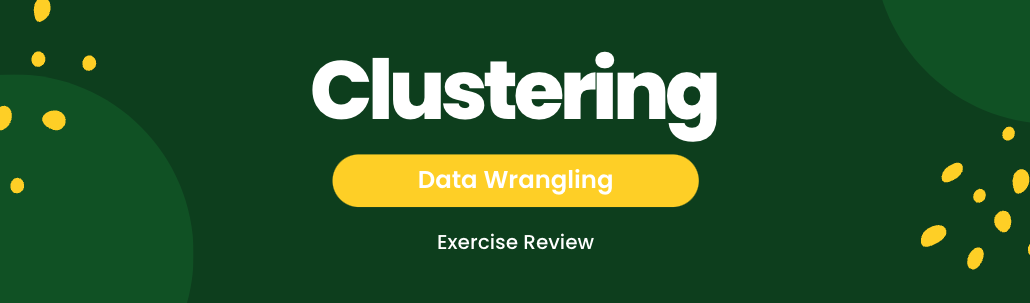

<hr style="border:2px solid gray">

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import wrangle as w

# Part I: Zillow

## Acquire and Summarize

### #1. Acquire data from the cloud database.

You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.

Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid. 
   - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) 
   - Only include properties that have a latitude and longitude value.

In [2]:
#URL function
def get_db_url(host, user, password, database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
#use our function inside env to create the url
url = w.get_connection_url('zillow')

#Create the SQL query
query = '''
        SELECT prop.* ,
            pred.logerror,
            pred.transactiondate,
            air.airconditioningdesc,
            arch.architecturalstyledesc,
            build.buildingclassdesc,
            heat.heatingorsystemdesc,
            land.propertylandusedesc,
            story.storydesc,
            type.typeconstructiondesc
        from properties_2017 prop
        JOIN ( -- used to filter all properties with their last transaction date in 2017, w/o dups
                SELECT parcelid, MAX(transactiondate) AS max_transactiondate
                FROM predictions_2017
                GROUP BY parcelid) trans using (parcelid)
        -- bringing in logerror & transaction_date cols
        JOIN predictions_2017 pred ON trans.parcelid = pred.parcelid
                          AND trans.max_transactiondate = pred.transactiondate
        -- bringing in all other fields related to the properties
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        -- exercise stipulations
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL;
        '''

In [4]:
#create the dataframe using the sql query and our url
df = pd.read_sql(query, url)

In [5]:
df = w.get_zillow_data()

local version found!


In [6]:
#take a look
df.head(3)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathrooms,bedrooms,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN


<hr style="border:1px solid black">

### #2. Summarize your data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          52319 non-null  int64  
 1   parcelid                    52319 non-null  int64  
 2   airconditioningtypeid       13615 non-null  float64
 3   architecturalstyletypeid    70 non-null     float64
 4   basementsqft                47 non-null     float64
 5   bathrooms                   52319 non-null  float64
 6   bedrooms                    52319 non-null  float64
 7   buildingclasstypeid         0 non-null      float64
 8   buildingqualitytypeid       33654 non-null  float64
 9   calculatedbathnbr           52184 non-null  float64
 10  decktypeid                  389 non-null    float64
 11  finishedfloor1squarefeet    4371 non-null   float64
 12  area                        52238 non-null  float64
 13  finishedsquarefeet12        520

In [8]:
df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       38704
architecturalstyletypeid    52249
basementsqft                52272
                            ...  
buildingclassdesc           52319
heatingorsystemdesc         18470
propertylandusedesc             0
storydesc                   52272
typeconstructiondesc        52243
Length: 68, dtype: int64

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,52319.0,1.496888e+06,8.594310e+05,3.490000e+02,7.575810e+05,1.500095e+06,2.241248e+06,2.982270e+06
parcelid,52319.0,1.299682e+07,3.350951e+06,1.071186e+07,1.151017e+07,1.257825e+07,1.413036e+07,1.676878e+08
airconditioningtypeid,13615.0,2.439589e+00,3.847925e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,70.0,7.100000e+00,2.665670e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,47.0,6.789787e+02,7.118252e+02,3.800000e+01,2.635000e+02,5.120000e+02,8.095000e+02,3.560000e+03
bathrooms,52319.0,2.300015e+00,1.022816e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedrooms,52319.0,3.300770e+00,9.475632e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
buildingclasstypeid,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,33654.0,6.264961e+00,1.716328e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,52184.0,2.305276e+00,1.018076e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


In [10]:
df.shape

(52319, 68)

SUMMARY REPORT
          
          
Dataframe head: 
        id  parcelid  airconditioningtypeid  architecturalstyletypeid  \
0  1727539  14297519                    NaN                       NaN   
1  1387261  17052889                    NaN                       NaN   
2    11677  14186244                    NaN                       NaN   

   basementsqft  bathrooms  bedrooms  buildingclasstypeid  \
0           NaN        3.5       4.0                  NaN   
1           NaN        1.0       2.0                  NaN   
2           NaN        2.0       3.0                  NaN   

   buildingqualitytypeid  calculatedbathnbr  ...  censustractandblock  \
0                    NaN                3.5  ...         6.059063e+13   
1                    NaN                1.0  ...         6.111001e+13   
2                    NaN                2.0  ...         6.059022e+13   

   logerror  transactiondate  airconditioningdesc  architecturalstyledesc  \
0  0.025595       2017-01-01          

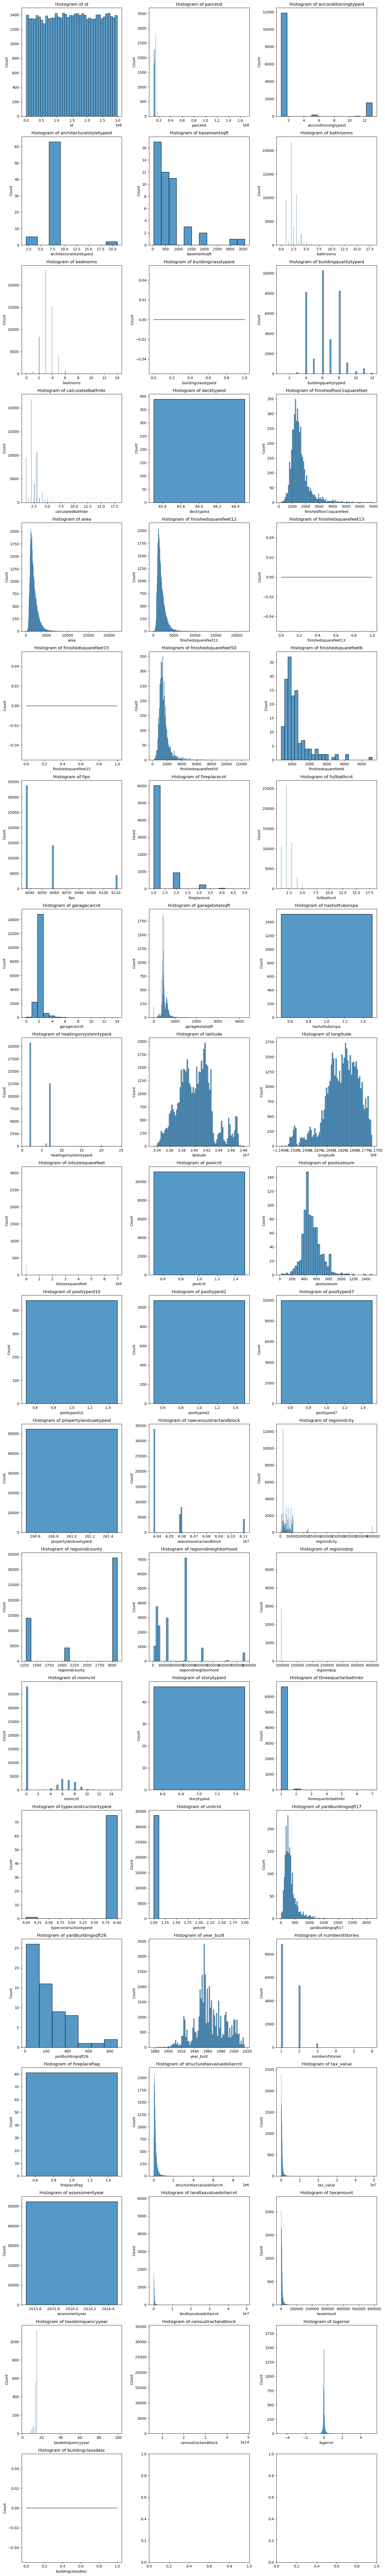

In [11]:
w.summarize(df, 'id')

<hr style="border:1px solid black">

### #3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name 
- The first column is the **number of rows** with *missing values* for that attribute
- The second column is **percent of total rows** that have *missing values* for that attribute. 
- Run the function and document takeaways from this on how you want to handle missing values.

In [12]:
def nulls_by_col(df):
    """
    This function will:
        - take in a dataframe
        - assign a variable to a Series of total row nulls for ea/column
        - assign a variable to find the percent of rows w/nulls
        - output a df of the two variables.
    """
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    
    pct_missing = (num_missing / rows) * 100
    cols_missing = pd.DataFrame({
                    'num_rows_missing': num_missing,
                    'percent_rows_missing': pct_missing
                    })
    
    return  cols_missing


In [13]:
nulls_by_col(df).sort_values(by='percent_rows_missing', ascending=False)

,num_rows_missing,percent_rows_missing
buildingclassdesc,52319,100.000000
buildingclasstypeid,52319,100.000000
finishedsquarefeet15,52319,100.000000
finishedsquarefeet13,52319,100.000000
storytypeid,52272,99.910166
...,...,...
latitude,0,0.000000
fips,0,0.000000
bedrooms,0,0.000000
bathrooms,0,0.000000


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>
    <br>
We may want to consider dropping some of the columns that have a high percent of nulls in them.
</div>

<hr style="border:1px solid black">
<hr style="border:1px solid black">

## Prepare

### #1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). 
- There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.
- ```propertylandusetypeid``` already tells us they are single unit properties <b>but</b> what if we didn't have this feature?? 

In [14]:
df.propertylandusetypeid.value_counts()

261.0    52319
Name: propertylandusetypeid, dtype: int64

<div class="alert alert-block alert-info">
<b>Note:</b> 
<br>
    
There are many ways to determine this.

</div>

In [15]:
#Maybe there are some houses with no square footage?
no_sqft = df[df['area'] == 0]
len(no_sqft)

0

In [16]:
#What about nonexistent lots?
no_lot = df[df['lotsizesquarefeet'] == 0]
len(no_lot)

0

In [17]:
#Maybe ones that have no bedrooms?
no_beds = df[df['bedrooms'] == 0]
len(no_beds)

135

In [18]:
#Maybe ones that have no bathrooms?
no_bath = df[df['bathrooms'] == 0]
len(no_bath)

119

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>
    <br>   
We may be able to determine that a home with:
<br>
    
- No square footage
<br>
- No lot
<br>
- No bedrooms
<br>
- No bathrooms
<br>
<br>
... is likely not a single family home?    
</div>

### #2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

In [19]:
def drop_based_on_pct(df, pc = 0.5, pr = 0.75):
    """
    drop_based_on_pct takes in: 
    - dataframe
    - threshold percent of non-null values for columns(# between 0-1)
        - defaulted at half/.5
    - threshold percent of non-null values for rows(# between 0-1)
        - defaulted at three-quarters/.75
    Returns: a dataframe with the columns and rows dropped as indicated.
    """
    
    df.dropna(axis = 1, thresh = pc * len(df.index), inplace = True)
    df.dropna(axis = 0, thresh = pr * len(df.columns), inplace = True)
    

    return df

In [20]:
#Let's use our function
clean_df = drop_based_on_pct(df, .75, .75)

#take a look
clean_df.head(3)

,id,parcelid,bathrooms,bedrooms,calculatedbathnbr,area,finishedsquarefeet12,fips,fullbathcnt,latitude,...,year_built,structuretaxvaluedollarcnt,tax_value,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,1727539,14297519,3.5,4.0,3.5,3100.0,3100.0,6059.0,3.0,33634931.0,...,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,Single Family Residential
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential


In [21]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52315 entries, 0 to 52318
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          52315 non-null  int64  
 1   parcelid                    52315 non-null  int64  
 2   bathrooms                   52315 non-null  float64
 3   bedrooms                    52315 non-null  float64
 4   calculatedbathnbr           52184 non-null  float64
 5   area                        52238 non-null  float64
 6   finishedsquarefeet12        52073 non-null  float64
 7   fips                        52315 non-null  float64
 8   fullbathcnt                 52184 non-null  float64
 9   latitude                    52315 non-null  float64
 10  longitude                   52315 non-null  float64
 11  lotsizesquarefeet           51952 non-null  float64
 12  propertycountylandusecode   52315 non-null  object 
 13  propertylandusetypeid       523

In [25]:
#use our function to see how many nulls we have left
null_clean = nulls_by_col(clean_df)

#take a look at top 10 null columns
null_clean.sort_values(by='percent_rows_missing', ascending=False).head(10)

,num_rows_missing,percent_rows_missing
regionidcity,1032,1.972666
lotsizesquarefeet,363,0.693874
finishedsquarefeet12,242,0.462582
calculatedbathnbr,131,0.250406
fullbathcnt,131,0.250406
censustractandblock,117,0.223645
year_built,110,0.210265
structuretaxvaluedollarcnt,80,0.152920
area,77,0.147185
regionidzip,23,0.043964


In [26]:
clean_df.shape

(52315, 29)

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>
    <br>   
The "clean" dataframe contains:
<br>
    
- 29 columns instead of 68 columns
<br>
- At the most, we have a column with ~2% nulls instead of 100% nulls
<br>
- The dataframe shape changed from (52319, 68) to (52315, 29)
</div>

### #3. Encapsulate your work inside of functions in a wrangle_zillow.py module.

<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

# Part II: Mall Customers

### #1. Acquire data from the customers table in the mall_customers database.

In [27]:
#use our function inside env to create the url
mall_url = w.get_connection_url('mall_customers')

#Create the SQL query
mall_query = '''
             SELECT *
             FROM customers
             '''

In [28]:
#Read in the dataset
mall_df = pd.read_sql(mall_query, mall_url)

In [29]:
mall_df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### #2. Summarize the data (include distributions and descriptive statistics).

SUMMARY REPORT
          
          
Dataframe head: 
   customer_id  gender  age  annual_income  spending_score
0            1    Male   19             15              39
1            2    Male   21             15              81
2            3  Female   20             16               6
          
          
          
Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
          
          
Dataframe Description: 
       customer_id         age  annual_income  spending_score
count   200.000000  200.000000     200.000000      200.000000
mean    100.500000   38.8500

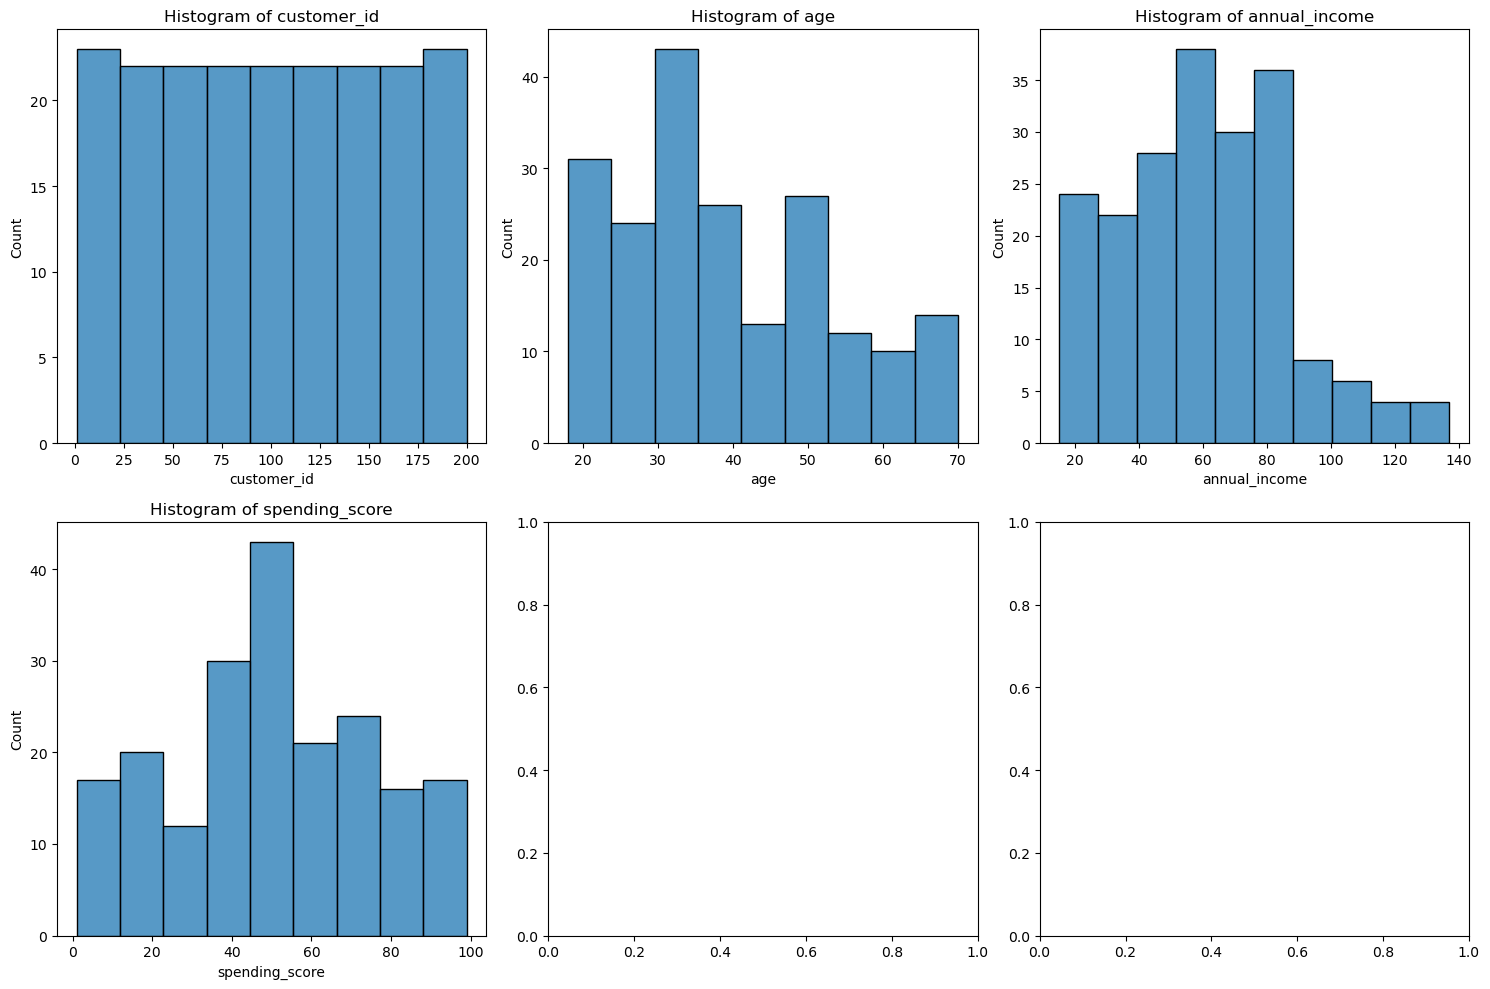

In [30]:
w.summarize(mall_df, 'customer_id')

In [31]:
mall_df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
annual_income,200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [32]:
mall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### #3. Detect outliers using IQR.

<div class="alert alert-block alert-info">
<b>Note:</b> 
<br>

<b>Quartiles</b>
<br>
- data is split into 4 equal parts
<br>
- a quartile represents one of these bins that captures exactly 25% of the data 
<br>
- 25% / 25% / 25% / 25%
<br>
    
<b>Bounds/IQR</b>    
- lower bound: Q1-(k*IQR)
<br>
- upper bound: Q3+(k*IQR)
    

</div>

In [33]:
#let's find our quantiles for age
mall_df['age'].quantile([0.25,0.75])

0.25    28.75
0.75    49.00
Name: age, dtype: float64

In [34]:
#another way to do this, numpy percentile function
q1, q3= np.percentile(mall_df['age'], [25, 75])
q1, q3

(28.75, 49.0)

In [35]:
#yet another way to do this, numpy quantile function
q1, q3 = np.quantile(mall_df['age'], [0.25, 0.75])
q1, q3

(28.75, 49.0)

In [36]:
def outlier(df, feature, m=1.5):
    '''
    outlier will take in a dataframe's feature:
    - calculate it's 1st & 3rd quartiles,
    - use their difference to calculate the IQR
    - then apply to calculate upper and lower bounds
    - using the `m` multiplier
    '''
    q1, q3 = df[feature].quantile([0.25, 0.75])
    
    iqr = q3 - q1
    
    upper_bound = q3 + (m * iqr)
    lower_bound = q1 - (m * iqr)
    
    print(f'For {feature}, the lower bound is {lower_bound} and  upper bound is {upper_bound}')
    
    return upper_bound, lower_bound


In [37]:
ageUP, ageLOW = outlier(mall_df, 'age')

For age, the lower bound is -1.625 and  upper bound is 79.375


In [38]:
ageUP, ageLOW

(79.375, -1.625)

In [39]:
#identify numeric columns only
num_df = mall_df.select_dtypes(exclude=object)
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer_id     200 non-null    int64
 1   age             200 non-null    int64
 2   annual_income   200 non-null    int64
 3   spending_score  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


In [40]:
##identify discrete columns only
disc_df = mall_df.select_dtypes(include=object)
disc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  200 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


In [45]:
#let's iterate through the list of numeric columns 
##to find the upper and lower bounds
cols = num_df.columns.to_list()    

for col in cols:
    outlier(num_df, col)

For customer_id, the lower bound is -98.5 and  upper bound is 299.5
For age, the lower bound is -1.625 and  upper bound is 79.375
For annual_income, the lower bound is -13.25 and  upper bound is 132.75
For spending_score, the lower bound is -22.625 and  upper bound is 130.375


### #4. Split data into train, validate, and test.

In [46]:
#function from wrangle.py
def split_data(df, target):
    '''
    This function take in a dataframe performs a train, validate, test split
    Returns train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test
    and prints out the shape of train, validate, test
    '''
    #create train_validate and test datasets
    train, test = train_test_split(df, train_size = 0.8, random_state = 123)
    #create train and validate datasets
    train, validate = train_test_split(train, train_size = 0.7, random_state = 123)

    #Split into X and y
    X_train = train.drop(columns=[target])
    y_train = train[target]

    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]

    X_test = test.drop(columns=[target])
    y_test = test[target]

    # Have function print datasets shape
    print(f'train -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test -> {test.shape}')
   
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [47]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = split_data(mall_df, 'spending_score')

train -> (112, 5)
validate -> (48, 5)
test -> (40, 5)


### #5. Encode categorical columns using a one hot encoder (pd.get_dummies).

<div class="alert alert-block alert-info">
<b>Note:</b> 
<br>
    
- The only column in this data that needs to be encoded is gender.

</div>

In [48]:
#Check get_dummies works as expected on my training data
dummy_df = pd.get_dummies(train)
dummy_df

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male
123,124,39,69,91,0,1
76,77,45,54,53,1,0
171,172,28,87,75,0,1
10,11,67,19,14,0,1
35,36,21,33,81,1,0
...,...,...,...,...,...,...
175,176,30,88,86,1,0
101,102,49,62,48,1,0
148,149,34,78,22,1,0
99,100,20,61,49,0,1


In [49]:
def encoding(df, cols, drop_first=True):
    '''
    Take in df and list of columns
    add encoded columns derived from columns in list to the df
    '''
    for col in cols:

        dummies = pd.get_dummies(df[f'{col}'], drop_first=drop_first) # get dummy columns

        df = pd.concat([df, dummies], axis=1) # add dummy columns to df
        
    return df

In [50]:
train_encoded = encoding(train, disc_df , drop_first=True)

In [51]:
train_encoded

,customer_id,gender,age,annual_income,spending_score,Male
123,124,Male,39,69,91,1
76,77,Female,45,54,53,0
171,172,Male,28,87,75,1
10,11,Male,67,19,14,1
35,36,Female,21,33,81,0
...,...,...,...,...,...,...
175,176,Female,30,88,86,0
101,102,Female,49,62,48,0
148,149,Female,34,78,22,0
99,100,Male,20,61,49,1


### #6. Handles missing values.

In [52]:
#count of nulls in the df
mall_df.isnull().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [56]:
#use null value counter function
null_malldf = nulls_by_col(mall_df)

#take a look
null_malldf.sort_values(by='percent_rows_missing', ascending=False)

,num_rows_missing,percent_rows_missing
customer_id,0,0.0
gender,0,0.0
age,0,0.0
annual_income,0,0.0
spending_score,0,0.0


### #7.Scaling

In [57]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 123 to 22
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     112 non-null    int64 
 1   gender          112 non-null    object
 2   age             112 non-null    int64 
 3   annual_income   112 non-null    int64 
 4   spending_score  112 non-null    int64 
 5   Male            112 non-null    uint8 
dtypes: int64(4), object(1), uint8(1)
memory usage: 5.4+ KB


<div class="alert alert-block alert-info">
<b>Note:</b> 
<br>

Only numeric columns typically need to be scaled.
<br>
- customer_id does not need to be scaled
<br>
- gender does not need to be scaled
<br>
- Male does not need to be scaled
<br>
- spending_score is our target so it also does not need to be scaled
</div>

In [58]:
#create the scaler
mms = MinMaxScaler()

#fit the scaler on the desired columns
train_encoded[['age', 'annual_income']] = mms.fit_transform(train_encoded[['age','annual_income']])

#take a look
train_encoded.head()

,customer_id,gender,age,annual_income,spending_score,Male
123,124,Male,0.403846,0.442623,91,1
76,77,Female,0.519231,0.319672,53,0
171,172,Male,0.192308,0.590164,75,1
10,11,Male,0.942308,0.032787,14,1
35,36,Female,0.057692,0.147541,81,0


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>
- We now have gender encoded (dummy variable)
<br>
- Age and annual income are scaled
</div>